# Experiments on Sinkhorn with translations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import logsumexp

import warnings
warnings.filterwarnings('ignore')

## Code for the methods
We provide below the code for the Sinkhorn algorithm and the optimal translation of the form $(f,g)\mapsto(f +t, g-t)$ and $(f,g)\mapsto(f +t, g+t)$.

In [3]:
def rescale(f, g, a, b, rho, rho2=None):
    """Translation (f + t, g - t)"""
    if rho2 is None:
        rho2=rho
    return ((rho * rho2) / (rho+rho2)) * (logsumexp(np.log(a) - f / rho) - logsumexp(np.log(b) - g / rho2))

def shift(f, g, a, b, C, eps, rho, rho2=None):
    """Translation (f+t, g+t)"""
    if rho2 is None:
        rho2=rho
    xa = np.sum(a * np.exp(-f / rho))
    xb = np.sum(b * np.exp(-g / rho2))
    xc = np.sum(a[:,None] * b[None,:] * np.exp((f[:,None] + g[None,:] - C) / eps))
    if rho2 is None:
        # Closed form when rho=rho2
        k = (eps * rho) / (eps + 2* rho)
        return k * (np.log(xa + xb) - np.log(2) - np.log(xc))
    else:
        # Newton step
        t = 0.0
        def grad(t):
            return xa * np.exp(-t / rho) + xb * np.exp(-t / rho2) - 2 * xc * np.exp(2 * t / eps)
        
        def hess(t):
            return  - xa * np.exp(-t / rho) / rho - xb * np.exp(-t / rho2) / rho2 - 4 * xc * np.exp(2 * t / eps) / eps
            
        for k in range(3):
            t = t + grad(t) / hess(t)
        return t

def sinkx(C, f, a, eps):
    return - eps * logsumexp(np.log(a)[:,None] + (f[:,None] - C) / eps, axis=0)

def sinky(C, g, b, eps):
    return - eps * logsumexp(np.log(b)[None,:] + (g[None,:] - C) / eps, axis=1)

def aprox(f, eps, rho):
    return (1. / (1. + (eps / rho))) * f

def hilbert(f):
    return (np.amax(f) - np.amin(f))

def dual_score(f, g, a, b, C, eps, rho, rho2=None):
    if rho2 is None:
        rho2=rho
        
    def phi(x,s):
        return -s * (np.exp(-x / s) - 1)
    
    return np.sum(a * phi(f, rho)) + np.sum(b * phi(g, rho2)) + np.sum(a[:,None] * b[None,:] * phi(C - f[:,None] - g[None,:], eps))

We agregate here the methods containing a whole Sinkhorn loop with additional variants.

In [4]:
def sinkhorn_loop(f, a, b, C, eps, rho, rho2=None):
    """Standard Sinkhorn loop"""
    if rho2 is None:
        rho2 = rho
    # Update on G
    g = sinkx(C, f, a, eps)
    g = aprox(g, eps, rho2)
    # Update on F
    f = sinky(C, g, b, eps)
    f = aprox(f, eps, rho)
    return f, g

def homogeneous_loop2(f, a, b, C, eps, rho, rho2=None):
    """Translation invariant loop with 1 translation"""
    if rho2 is None:
        rho2 = rho
    # Update on G
    g = sinkx(C, f, a, eps)
    g = aprox(g, eps, rho2)
    
    # Update on F
    f = sinky(C, g, b, eps)
    f = aprox(f, eps, rho)
    t = rescale(f,g,a,b, rho, rho2)
    
    return f + t, g - t


def homogeneous_loop(f, a, b, C, eps, rho, rho2=None):
    """Translation invariant loop with 2 translations"""
    if rho2 is None:
        rho2 = rho
    # Update on G
    g = sinkx(C, f, a, eps)
    g = aprox(g, eps, rho2)
    t = rescale(f,g,a,b, rho, rho2)
    g = g - t
    
    # Update on F
    f = sinky(C, g, b, eps)
    f = aprox(f, eps, rho)
    t = rescale(f,g,a,b, rho, rho2)
    f = f + t
    
    return f, g

def shift_loop(f, a, b, C, eps, rho, rho2=None):
    """Translation loop with (f+t,g+t)"""
    if rho2 is None:
        rho2 = rho
    # Update on G
    g = sinkx(C, f, a, eps)
    g = aprox(g, eps, rho2)
    t = shift(f, g, a, b, C, eps, rho, rho2=None)
    g = g + t
    
    # Update on F
    f = sinky(C, g, b, eps)
    f = aprox(f, eps, rho)
    t = shift(f, g, a, b, C, eps, rho, rho2=None)
    f = f + t
    
    return f, g

def full_loop(f, a, b, C, eps, rho, rho2=None):
    """Loop with both translations"""
    if rho2 is None:
        rho2 = rho
    # Update on G
    g = sinkx(C, f, a, eps)
    g = aprox(g, eps, rho2)
    ts = shift(f, g, a, b, C, eps, rho, rho2)
    tr = rescale(f + ts, g + ts, a, b, rho, rho2)
    g = g + ts - tr

    # Update on F
    f = sinky(C, g, b, eps)
    f = aprox(f, eps, rho)
    ts = shift(f, g, a, b, C, eps, rho, rho2)
    tr = rescale(f + ts, g + ts, a, b, rho, rho2)
    f, g = f + ts + tr, g + ts -tr

    return f, g

def balanced_loop(f, a, b, C, eps):
    """Balanced Sinkhorn loop"""
    # Update on G
    g = sinkx(C, f, a, eps)
    # Update on F
    f = sinky(C, g, b, eps)
    return f, g

Now we initialize the data for a fixed seed.

In [5]:
np.random.seed(0)
N, M = 10, 11
a, b = np.random.exponential(size=N), np.random.exponential(size=M)
a, b = a / np.sum(a), b / np.sum(b)
x, y = np.random.normal(size=N), np.random.normal(size=M)
C = (x[:,None] - y[None,:])**2
eps, rho = 0.05, 10.

## XP1 - Convergence for Sinkhorn and marginal equalization for fixed $\epsilon / \rho$

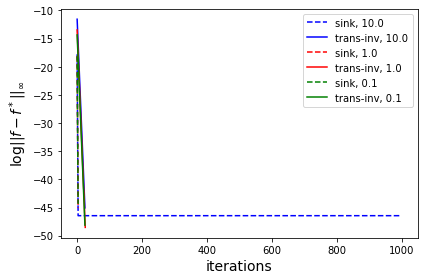

In [9]:
eps, rho = 0.05, 10.
scale = [10., 1., 0.1]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(1000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rhot)
        err_sink.append(np.amax(np.abs(f - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'trans-inv, {scale[p]}')

plt.xlabel('iterations', fontsize=14)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=14)
plt.legend()
plt.tight_layout()
# plt.savefig('plot_sinkhorn_ratio_fixed.eps', format='eps')
plt.show()

## XP2 - Convergence for Sinkhorn and marginal equalization for fixed $\rho$

Error at convergence = 6.661338147750939e-16
Error at convergence = 2.220446049250313e-16
Error at convergence = 0.0
Error at convergence = 0.0


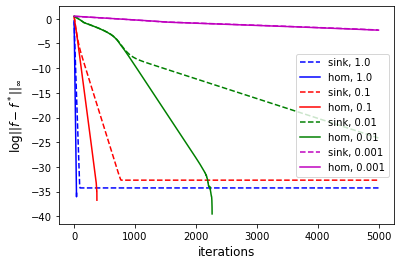

In [6]:
rho = 5.
epsarr = [1., 0.1, 0.01, 0.001]
col = ['b', 'r', 'g', 'm']
for p in range(len(epsarr)):
    epst = epsarr[p]
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rho)
        
    finf, ginf = sinkhorn_loop(fr, a, b, C, epst, rho)
    print(f"Error at convergence = {np.amax(np.abs(finf - fr))}")
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(5000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rho)
        err_sink.append(np.amax(np.abs(f - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(5000):
        f, g = homogeneous_loop(f, a, b, C, epst, rho)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {epsarr[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {epsarr[p]}')

plt.legend()
plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=12)
plt.show()

## XP3 - Convergence for Sinkhorn and marginal equalization for fixed $\epsilon$

Error at convergence = 0.0
Error at convergence = 0.0
Error at convergence = 0.0
Error at convergence = 1.3877787807814457e-17


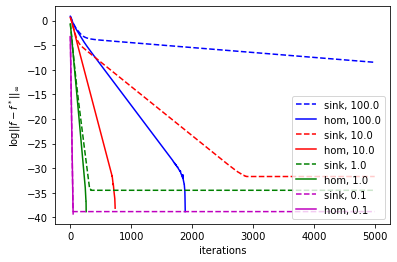

In [35]:
eps = 0.005
eps= .05
rhoarr = [100., 10., 1., 0.1]
col = ['b', 'r', 'g', 'm']
for p in range(len(rhoarr)):
    rhot = rhoarr[p]
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, eps, rhot)
        
    finf, ginf = sinkhorn_loop(fr, a, b, C, eps, rhot)
    print(f"Error at convergence = {np.amax(np.abs(finf - fr))}")
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(5000):
        f, g = sinkhorn_loop(f, a, b, C, eps, rhot)
        err_sink.append(np.amax(np.abs(f - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(5000):
        f, g = homogeneous_loop(f, a, b, C, eps, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {rhoarr[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {rhoarr[p]}')

plt.xlabel('iterations')
plt.ylabel('$\log||f - f^*||_\infty$')
plt.legend(loc=4)
plt.show()

## XP4 - Compare all Sinkhorn variants for fixed ratio 

Error at convergence = 0.0


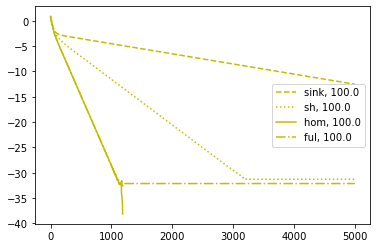

Error at convergence = 4.440892098500626e-16


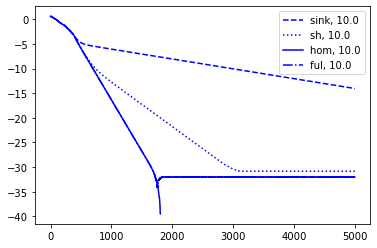

Error at convergence = 0.0


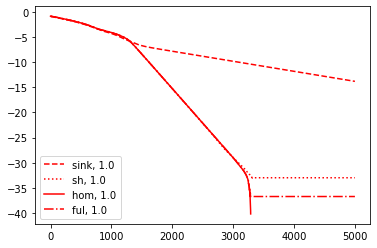

Error at convergence = 8.023096076392733e-18


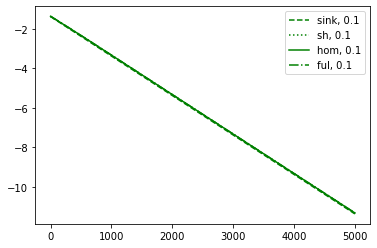

Error at convergence = 1.734723475976807e-18


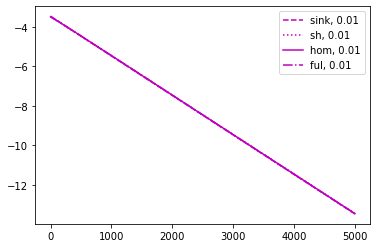

In [16]:
eps, rho = .001, 1.
scale = [100., 10., 1., 0.1, 0.01]
col = ['y', 'b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
        
    finf, ginf = sinkhorn_loop(fr, a, b, C, epst, rhot)
    print(f"Error at convergence = {np.amax(np.abs(finf - fr))}")
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    err_st = []
    for i in range(5000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rhot)
        err_sink.append(np.amax(np.abs(f - fr)))
#         t = rescale(f, g, a, b, rho, rho2=None)
#         err_st.append(np.amax(np.abs(f + t - fr)))
#     plt.plot(np.log(np.array(err_st)), color=col[p], linestyle='dashdot', label=f's+t, {scale[p]}')
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sh = []
    for i in range(5000):
        f, g = shift_loop(f, a, b, C, epst, rhot)
        err_sh.append(np.amax(np.abs(f - fr)))
    plt.plot(np.log(np.array(err_sh)), color=col[p], linestyle='dotted', label=f'sh, {scale[p]}')
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(5000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {scale[p]}')
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_ful = []
    for i in range(5000):
        f, g = full_loop(f, a, b, C, epst, rhot)
        err_ful.append(np.amax(np.abs(f - fr)))
    plt.plot(np.log(np.array(err_ful)), color=col[p], linestyle='dashdot', label=f'ful, {scale[p]}')


    plt.legend()
    plt.show()

Error at convergence = 0.0


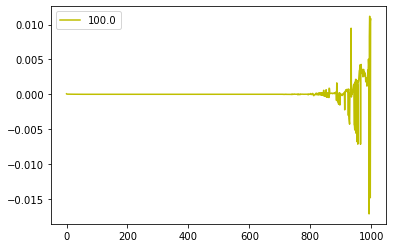

Error at convergence = 4.440892098500626e-16


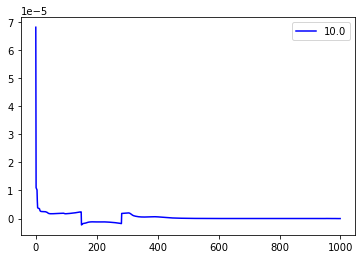

Error at convergence = 0.0


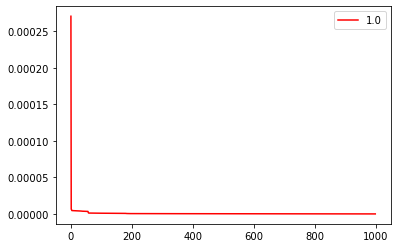

Error at convergence = 8.023096076392733e-18


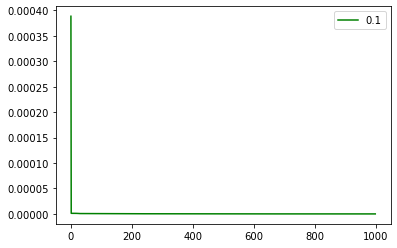

Error at convergence = 1.734723475976807e-18


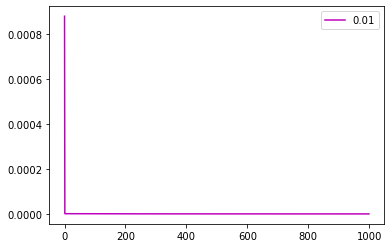

In [7]:
eps, rho = .001, 1.
scale = [100., 10., 1., 0.1, 0.01]
col = ['y', 'b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
        
    finf, ginf = sinkhorn_loop(fr, a, b, C, epst, rhot)
    print(f"Error at convergence = {np.amax(np.abs(finf - fr))}")
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_ful = []
    for i in range(1000):
        f, g = full_loop(f, a, b, C, epst, rhot)
        err_ful.append(np.amax(np.abs(f - fr)))
        
    # Plot difference of convergence
    res = np.log(np.array(err_ful)) - np.log(np.array(err_hom))
    plt.plot(res, color=col[p], label=f'{scale[p]}')


    plt.legend()
    plt.show()

# XP5 - compare homogeneous Sinkhorn with balanced Sinkhorn

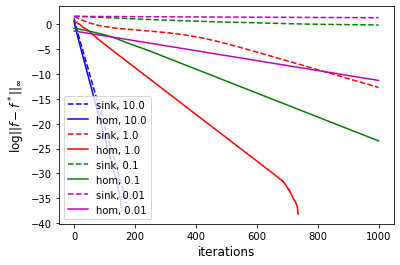

In [8]:
eps, rho = 0.05, 10.
scale = [10., 1., 0.1, 0.01]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    ####################################################################
    # BALANCED SINKHORN
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = balanced_loop(fr, a, b, C, epst)
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(1000):
        f, g = balanced_loop(f, a, b, C, epst)
        err_sink.append(hilbert(f - fr))
    
    ########################################################################
    # HOMOGENEOUS SINKHORN
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {scale[p]}')
#     print("Slope = ", -1 / (1 + (eps / rho)))
#     print("Estimation of slope = ", (np.log(np.array(err_sink))[-1] - np.log(np.array(err_sink))[500]) / 500)
#     print("Estimation of slope = ", (np.log(np.array(err_hom))[150] - np.log(np.array(err_hom))[50]) / 100)
#     print('\n\n')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=12)
plt.legend()
plt.show()

# XP6 - compare homogeneous Sinkhorn with hilbert distance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


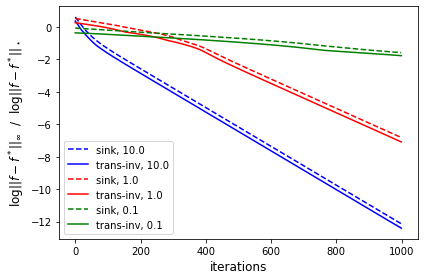

In [12]:
eps, rho = 0.01, 10.
scale = [10., 1., 0.1]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    ########################################################################
    # HOMOGENEOUS SINKHORN
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom, err_sink = [], []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
        err_sink.append(hilbert(f - fr))
    
#     l0, l1 = np.log(np.array(err_sink))[0], np.log(np.array(err_hom))[0]
#     plt.plot(np.log(np.array(err_sink))-l0 + l1, color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
    plt.plot(np.log10(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
    plt.plot(np.log10(np.array(err_hom)), color=col[p], label=f'trans-inv, {scale[p]}')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$  /  $\log||f - f^*||_\star$', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('plot_sinkhorn_vs_hilbert.eps', format='eps')
plt.show()

# XP7 - Compare Sinkhorn and Homogeneous wrt Hilbert distance

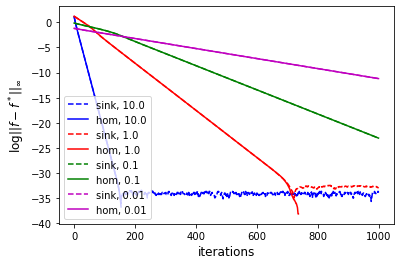

In [7]:
eps, rho = 0.05, 10.
scale = [10., 1., 0.1, 0.01]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(1000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rhot)
        err_sink.append(hilbert(f - fr))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_hom.append(hilbert(f - fr))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'sink, {scale[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {scale[p]}')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=12)
plt.legend()
plt.show()

# XP8 - Compare (Homogeneous) vs. (Sink+Final translation)

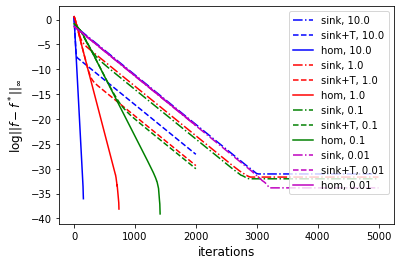

In [5]:
eps, rho = 0.05, 10.
scale = [10., 1., 0.1, 0.01]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop2(fr, a, b, C, epst, rhot)
        
    # compute norm for sinkhorn + translation
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(5000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rhot)
        err_sink.append(np.amax(np.abs(f - fr)))
    
    # compute norm for sinkhorn + translation
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink_t = []
    for i in range(2000):
        f, g = sinkhorn_loop(f, a, b, C, epst, rhot)
        t = rescale(f,g,a,b, rhot)
        err_sink_t.append(np.amax(np.abs(f + t - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(2000):
        f, g = homogeneous_loop2(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashdot', label=f'sink, {scale[p]}')
    plt.plot(np.log(np.array(err_sink_t)), color=col[p], linestyle='dashed', label=f'sink+T, {scale[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'hom, {scale[p]}')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=12)
plt.legend()
plt.show()

# XP9 - Evolution of the parameter $\lambda$

Error at convergence = 0.0
Error at convergence = 0.0
Error at convergence = 0.0
Error at convergence = 0.0


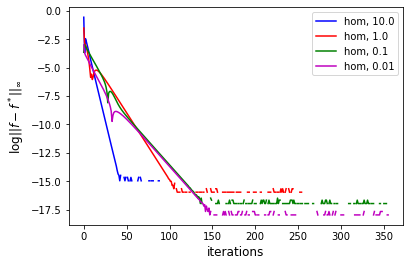

In [40]:
eps, rho = 0.05, 1.
scale = [10., 1., 0.1, 0.01]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    t = 0.
    err_sink = []
    for i in range(1000):
        f, g = sinkhorn_loop(f + t, a, b, C, epst, rhot)
        t = rescale(f,g,a,b, rhot)
        err_sink.append(np.abs(t))
        
    finf, ginf = sinkhorn_loop(f, a, b, C, epst, rhot)
    print(f"Error at convergence = {np.amax(np.abs(finf - f))}")
    
    plt.plot(np.log10(np.array(err_sink)), color=col[p], label=f'hom, {scale[p]}')

plt.xlabel('iterations', fontsize=12)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=12)
plt.legend()
plt.show()

# Comparison of TI-Sinkhorn with 1 or 2 translations

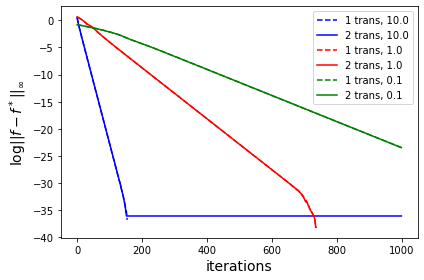

In [6]:
eps, rho = 0.05, 10.
scale = [10., 1., 0.1]
col = ['b', 'r', 'g', 'm']
for p in range(len(scale)):
    epst, rhot = scale[p] * eps, scale[p] * rho
    
    # Compute reference
    fr, gr = np.zeros_like(a), np.zeros_like(b)
    for i in range(50000):
        fr, gr = homogeneous_loop(fr, a, b, C, epst, rhot)
    
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_sink = []
    for i in range(1000):
        f, g = homogeneous_loop(f, a, b, C, epst, rhot)
        err_sink.append(np.amax(np.abs(f - fr)))
        
    # compute norm for sinkhorn
    f, g = np.zeros_like(a), np.zeros_like(b)
    err_hom = []
    for i in range(1000):
        f, g = homogeneous_loop2(f, a, b, C, epst, rhot)
        err_hom.append(np.amax(np.abs(f - fr)))
    
    plt.plot(np.log(np.array(err_sink)), color=col[p], linestyle='dashed', label=f'1 trans, {scale[p]}')
    plt.plot(np.log(np.array(err_hom)), color=col[p], label=f'2 trans, {scale[p]}')

plt.xlabel('iterations', fontsize=14)
plt.ylabel('$\log||f - f^*||_\infty$', fontsize=14)
plt.legend()
plt.tight_layout()
# plt.savefig('plot_sinkhorn_ratio_fixed.eps', format='eps')
plt.show()

blabla

# Anderson Acceleration

In [9]:
def anderson_sinkhorn_loop(f, a, b, C, eps, rho, K, reg):
    U = np.zeros((K+1, f.shape[0]))
    U[0] = f
    for k in range(K):
        f, g = sinkhorn_loop(f, a, b, C, eps, rho)
        U[k + 1] = f
    L = U[1:,:] - U[:-1,:]
    L = L.dot(L.T)
    c = np.linalg.solve(L + reg * np.eye(K), np.ones(K))
    c = c / np.sum(c)
    return c.dot(U[:-1,:])

def anderson_homogeneous_loop(f, a, b, C, eps, rho, K, reg):
    U = np.zeros((K+1, f.shape[0]))
    U[0] = f
    for k in range(K):
        f, g = homogeneous_loop(f, a, b, C, eps, rho)
        U[k + 1] = f
    L = U[1:,:] - U[:-1,:]
    L = L.dot(L.T)
    c = np.linalg.solve(L + reg * np.eye(K), np.ones(K))
    c = c / np.sum(c)
    return c.dot(U[:-1,:])

In [10]:
f = np.ones_like(a)
anderson_sinkhorn_loop(f, a, b, C, eps, rho, K=3, reg=0.01)

array([0.95593256, 0.87209904, 0.98388858, 0.97393349, 0.98366371,
       1.02054517, 0.93489945, 1.25086262, 1.20682904, 1.05674575])

Error at convergence = 4.440892098500626e-16


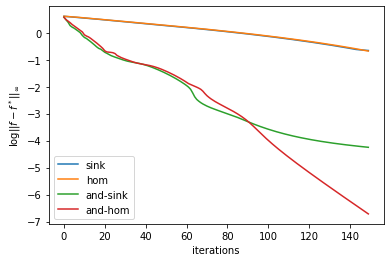

In [13]:
eps = 0.01
rho = 10.
K, reg = 6, 1e-6
Niter_and = 2000
    
# Compute reference
fr, gr = np.zeros_like(a), np.zeros_like(b)
for i in range(50000):
    fr, gr = homogeneous_loop(fr, a, b, C, eps, rho)

finf, ginf = sinkhorn_loop(fr, a, b, C, eps, rho)
print(f"Error at convergence = {np.amax(np.abs(finf - fr))}")

# compute norm for sinkhorn
f, g = np.zeros_like(a), np.zeros_like(b)
err_sink = []
for i in range(Niter_and):
    f, g = sinkhorn_loop(f, a, b, C, eps, rho)
    err_sink.append(np.amax(np.abs(f - fr)))
plt.plot(np.log(np.array(err_sink)), label=f'sink')

# compute norm for homogeneous
f, g = np.zeros_like(a), np.zeros_like(b)
err_hom = []
for i in range(Niter_and):
    f, g = homogeneous_loop(f, a, b, C, eps, rho)
    err_hom.append(np.amax(np.abs(f - fr)))
plt.plot(np.log(np.array(err_hom)), label=f'hom')

# compute norm for ANDERSON sinkhorn
f, g = np.zeros_like(a), np.zeros_like(b)
err_and_sink = []
for i in range(Niter_and):
    f = anderson_sinkhorn_loop(f, a, b, C, eps, rho, K, reg)
    err_and_sink.append(np.amax(np.abs(f - fr)))
plt.plot(np.log(np.array(err_and_sink)), label=f'and-sink')


# compute norm for ANDERSON homogensous
f, g = np.zeros_like(a), np.zeros_like(b)
err_and_hom = []
for i in range(Niter_and):
    f = anderson_homogeneous_loop(f, a, b, C, eps, rho, K, reg)
    err_and_hom.append(np.amax(np.abs(f - fr)))
plt.plot(np.log(np.array(err_and_hom)), label=f'and-hom')


plt.xlabel('iterations')
plt.ylabel('$\log||f - f^*||_\infty$')
plt.legend()
plt.show()

# Eigengap of Hessian
We wish to quantify the convergence by studying the Hessian. We evaluate it at the optimal potentials with zero translation $(f^*, g^*,0)$, then compute the eigengap of the Hessian and its submatrix corresponding to the Hessian of $(f^*,g^*)$

In [24]:
np.random.seed(0)
N, M = 10, 11
a, b = np.random.exponential(size=N), np.random.exponential(size=M)
a, b = a / np.sum(a), b / np.sum(b)
x, y = np.random.normal(size=N), np.random.normal(size=M)
C = (x[:,None] - y[None,:])**2

eps, rho = 100., 10.
# rho = float("Inf")

# Compute reference
fr, gr = np.zeros_like(a), np.zeros_like(b)
for i in range(50000):
    fr, gr = homogeneous_loop(fr, a, b, C, eps, rho)

In [25]:
H = np.zeros((N + M + 1, N + M + 1))
H[:N, :N] = np.diag(-a * np.exp(-fr / rho) / rho - a *np.sum(b[None,:] * np.exp((fr[:,None] + gr[None,:]-C) / eps), axis=1)) /eps
H[N:N+M, N:N+M] = np.diag(-b * np.exp(-gr / rho) / rho - b *np.sum(a[:,None] * np.exp((fr[:,None] + gr[None,:]-C) / eps), axis=0)) /eps
H[:N, N:N+M] = - a[:,None] * b[None,:] * np.exp((fr[:,None] + gr[None,:]-C) / eps) / eps
H[N:N+M, :N] = H[:N, N:N+M].T
H[-1, :N] = - a * np.exp(-fr / rho) / rho
H[:N, -1] = H[-1, :N].T
H[-1, N:N + M] =  b * np.exp(-gr / rho) / rho
H[N:N + M, -1] = H[-1, N:N + M].T
H[-1,-1] = -np.sum(a * np.exp(-fr / rho)) / rho - np.sum(b * np.exp(-gr / rho)) / rho
# np.set_printoptions(precision=4)
# print(H)

In [26]:
vals = np.linalg.eigvalsh(-H)
print(vals)
vals_sub = np.linalg.eigvalsh(-H[:N+M, :N+M])
print(vals_sub)

[-1.32178104e-02  1.46858199e-05  5.20816698e-05  6.43548783e-05
  4.43721934e-04  5.00940748e-04  5.37355728e-04  5.45421930e-04
  6.27140303e-04  7.21188803e-04  7.62012175e-04  8.72705327e-04
  1.01236441e-03  1.09785209e-03  1.17769762e-03  1.28421037e-03
  1.36184771e-03  1.61202865e-03  2.13539828e-03  2.35605491e-03
  3.80833986e-03  2.09440916e-01]
[1.45592371e-05 4.94253083e-05 6.11443554e-05 1.15585315e-04
 4.47920085e-04 5.03542586e-04 5.37401088e-04 5.65376821e-04
 6.46831344e-04 7.21252420e-04 7.79401618e-04 8.87802793e-04
 1.03675191e-03 1.09946131e-03 1.17954668e-03 1.31240792e-03
 1.41638726e-03 1.69885866e-03 2.14967076e-03 2.48829025e-03
 3.81374805e-03]


In [27]:
gap = vals[-1] - vals[-2]
gap_sub = vals_sub[-1] - vals_sub[-2]
print(gap)
print(gap_sub)
print(gap_sub / gap)

0.20563257649210326
0.001325457800463265
0.0064457578807517665
